# BSPF Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import obspy as obs
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [2]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from functions.compute_linear_regression import __compute_linear_regression

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

config['path_to_data'] = data_path+"BSPF/data/"

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['path_to_figs'] = data_path+"BSPF/figures/"

config['catalog'] = ""

config['save'] = False

config['translation_type'] = "ACC"

# config['catalog'] = "BSPF_catalog_20221001_20230930_all.pkl"
config['catalog'] = "BSPF_catalog_20221001_20231001_all.pkl"

## Load Data

In [5]:
# data_amax_disp = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_amax_disp.pkl")

# data_snr = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_snr_disp.pkl")

In [6]:
data_amax = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_amax_{config['translation_type']}.pkl")

data_snr = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_snr_{config['translation_type']}.pkl")

data_adr = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_adr_{config['translation_type']}.pkl")

In [7]:
data_amax_cosum_6 = data_amax[data_amax.CoincidenceSum == 6]

data_snr_cosum_6 = data_snr[data_snr.CoincidenceSum == 6]

In [8]:
## read data frame of selected triggered events
events = pd.read_pickle(config['path_to_catalogs']+config['catalog'])

events['Hdistance_km'] = np.sqrt((events.depth/1000)**2 + events.distances_km**2)

events_not_triggered = events.reset_index().rename(columns={"index":"origin"}).copy()

events_not_triggered = events_not_triggered[~events_not_triggered.origin.isin(data_amax_cosum_6.origin.values)]

## Modify Data

Filter data

In [9]:
## reject nan values
print(f" AMAX:  all: {data_amax.origin.size} no_nan: {data_amax.origin.dropna().shape[0]}")
data_amax.origin.dropna(inplace=True)

print(f" SNR:  all: {data_snr.origin.size} no_nan: {data_snr.origin.dropna().shape[0]}")
data_snr.origin.dropna(inplace=True)

print(f" CoSum6:  all: {data_amax_cosum_6.origin.size} no_nan: {data_amax_cosum_6.origin.dropna().shape[0]}")
data_amax_cosum_6.origin.dropna(inplace=True)

 AMAX:  all: 341 no_nan: 341
 SNR:  all: 341 no_nan: 341
 CoSum6:  all: 196 no_nan: 196


/tmp/ipykernel_6794/4006315242.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_amax_cosum_6.origin.dropna(inplace=True)


In [10]:
data_amax_cosum_6.dropna(inplace=True)
data_amax_cosum_6

/tmp/ipykernel_6794/2026196946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_amax_cosum_6.dropna(inplace=True)


,Torigin,Magnitude,CoincidenceSum,Mag_type,BAZ,Edistance_km,Hdistance_km,origin,BSPF__E_amax,BSPF__N_amax,...,PFO_10_Z_amax,RPFO_al_E_amax,RPFO_al_N_amax,RPFO_al_Z_amax,RPFO_in_E_amax,RPFO_in_N_amax,RPFO_in_Z_amax,RPFO_mi_E_amax,RPFO_mi_N_amax,RPFO_mi_Z_amax
1,2022-10-01 21:26:43.530,2.08,6.0,ml,328.065144,48.053535,50.379154,2022-10-01 21:26:43.530,2.271877e-07,2.589748e-07,...,0.000136,7.459161e-09,4.995607e-09,6.377297e-09,4.896136e-08,4.534828e-08,5.884933e-08,3.056737e-08,1.232587e-08,2.568925e-08
2,2022-10-02 03:25:16.440,1.49,6.0,ml,199.394033,14.850966,16.887652,2022-10-02 03:25:16.440,2.960972e-07,1.221093e-06,...,0.000275,1.041035e-08,9.264360e-09,1.662766e-08,1.492401e-07,1.105245e-07,2.970943e-07,4.427952e-08,2.643075e-08,4.399588e-08
3,2022-10-02 15:51:37.180,1.68,6.0,ml,159.749086,15.423592,17.486703,2022-10-02 15:51:37.180,2.619941e-07,2.569676e-07,...,0.000226,1.154502e-08,6.811005e-09,4.657963e-09,1.165987e-07,7.326951e-08,6.710577e-08,2.789285e-08,2.545662e-08,1.495532e-08
4,2022-10-02 21:52:54.280,0.99,6.0,ml,199.820062,14.772415,17.645021,2022-10-02 21:52:54.280,1.244038e-07,3.959991e-07,...,0.000078,3.005197e-09,2.587965e-09,4.777427e-09,3.384857e-08,2.973183e-08,6.666342e-08,1.238480e-08,5.539927e-09,1.111115e-08
6,2022-10-04 22:33:48.370,1.00,6.0,ml,198.791501,14.250442,17.443586,2022-10-04 22:33:48.370,1.874542e-07,3.491360e-07,...,0.000070,2.292683e-09,2.717151e-09,4.048056e-09,6.973245e-08,4.463389e-08,1.017734e-07,1.191491e-08,7.081809e-09,1.107201e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2023-09-16 16:49:57.560,2.64,6.0,ml,331.135140,53.575795,54.898873,2023-09-16 16:49:57.560,5.853553e-07,8.331053e-07,...,0.000506,4.469102e-09,6.353708e-09,3.353259e-09,2.710646e-08,2.268138e-08,3.208338e-08,8.957641e-09,1.003379e-08,1.207230e-08
333,2023-09-18 02:23:22.570,1.27,6.0,ml,211.487677,14.777495,18.960716,2023-09-18 02:23:22.570,4.632948e-07,1.063274e-06,...,0.000199,7.479123e-10,1.537265e-09,1.178093e-09,5.320975e-09,1.580573e-08,1.089432e-08,2.902639e-09,2.940245e-09,5.073746e-09
338,2023-09-21 01:58:24.210,0.68,6.0,ml,179.675029,7.188470,8.682799,2023-09-21 01:58:24.210,3.339117e-07,4.709163e-07,...,0.000112,1.049038e-09,1.106920e-09,8.390747e-10,4.403653e-09,1.037130e-08,3.049903e-09,2.449495e-09,1.738480e-09,7.868752e-10
339,2023-09-27 13:41:07.510,1.18,6.0,ml,216.668239,15.777807,20.719655,2023-09-27 13:41:07.510,6.284099e-07,8.418214e-07,...,0.000192,8.097221e-10,6.927176e-10,1.109903e-09,6.582034e-09,1.562864e-08,2.104055e-08,2.254142e-09,2.320868e-09,7.454474e-09


In [11]:
# ## reject all magnitude types not ml
# nn = [mm for mm in data_amax.Mag_type if mm != "ml"]

# data_amax_disp = data_amax[data_amax.Mag_type == "ml"]
# data_snr = data_snr[data_snr.Mag_type == "ml"]

# print(f"\n -> rejected {len(nn)} events: {nn}")

In [12]:
data_snr_cosum_6.shape, data_amax_cosum_6.shape

((196, 27), (171, 27))

## Plots

In [13]:
def __makeplot(data1, data2, data3, data4):

    import matplotlib

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    font=14

    cmap = plt.get_cmap("viridis", 9)

    # dat = np.log10(data4.BSPF__N_snr)
    dat = np.log10(data4.PFO_10_Z_snr)


    ax.scatter(data1.Hdistance_km, data1.Magnitude, s=30, color="grey", zorder=1, label=f"all (N={len(data1)})")

    cax = ax.scatter(data2.Hdistance_km, data2.Magnitude, s=50, lw=0.5, edgecolors="k",
                     c=dat, cmap=cmap, zorder=2, label=f"CoSum6 (N={len(data2)})", vmin=round(min(dat),1), vmax=4.5)

    ax.grid(ls="--", color="grey", alpha=0.6, zorder=0,which="both")
    ax.legend(loc=4, fontsize=font)

    ax.set_ylabel("Magnitude", fontsize=font)
    ax.set_xlabel("Hypocenter Distance (km)", fontsize=font)

    ax.set_xscale("log")
    ax.set_xlim(left=10)

    cbar = plt.colorbar(cax, pad=0.02)
    cbar.set_label(r"log$_{10}$(signal-to-noise ratio)", fontsize=font)
#     cbar.set_clim(0,4)

    ax.set_xticks([10, 20, 30, 40, 50, 100])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    plt.show()

# __makeplot(data_amax, data_amax_cosum_6, data_snr, data_snr_cosum_6)

## Magnitude Scale 

$M_L = log_{10} (A_{max}) + 1.11 log_{10} (R) + 0.00189 R - 2.09$   (adopted local magnitude scale)

with $R$ = hypocentral distance in km and $A_{max}$ = maximal amplitude in nm

In [14]:
def __ml(amax, hdist):
    return np.log10(amax) + 1.11*np.log10(hdist) + 0.00189*hdist -2.09

In [15]:
# ## reject nan values
# print(f" AMAX:  all: {data_amax.origin.size} no_nan: {data_amax.dropna().shape[0]}")
# data_amax.dropna(inplace=True)

In [16]:
# ## reject all magnitude types not ml
# nn = [mm for mm in data_amax.Mag_type if mm != "ml"]
# data_amax = data_amax[data_amax.Mag_type == "ml"]
# print(f"\n -> rejected {len(nn)} events: {nn}")

In [17]:
mm_z = __ml(data_amax.PFO_10_Z_amax*1e6, data_amax.Hdistance_km)
mm_n = __ml(data_amax.PFO_10_N_amax*1e6, data_amax.Hdistance_km)
mm_e = __ml(data_amax.PFO_10_E_amax*1e6, data_amax.Hdistance_km)

mm_t = __ml(data_amax.PFO_10_T_amax*1e6, data_amax.Hdistance_km)
mm_r = __ml(data_amax.PFO_10_R_amax*1e6, data_amax.Hdistance_km)


In [18]:
def __makeplot_magnitude_comparison():

    fig, ax = plt.subplots(1,3, figsize=(15,4))

    ax[0].scatter(hdist, mm, color='k', zorder=3)
    ax[0].scatter(hdist, mm_z, s=15, zorder=3, label="Z", edgecolors="tab:orange", color="tab:orange", alpha=0.7)
    ax[0].scatter(hdist, mm_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0].scatter(hdist, mm_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0].grid(zorder=0, alpha=0.4)
    ax[0].legend(loc=4)

    ax[0].set_xlabel(r"log$_{10}$( Hypocentral Distance ) (km)")
    ax[0].set_ylabel("Magnitude")

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mm, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1].hist(mm, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    ax[1].hist(mm_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:orange", edgecolor="tab:orange", rwidth=0.7, fill=False, align="mid", label="Z")
    ax[1].hist(mm_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.5, fill=False, align="mid", label="N")
    ax[1].hist(mm_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.3, fill=False, align="mid", label="E")
    ax[1].set_xticks(bars)
    # ax[1].set_xticks(bars+dbars/2)
    # ax[1].set_xticklabels([f"{b}-{b+dbars}" for b in bars], rotation=60)

    ax[1].legend(loc=1)
    ax[1].grid(zorder=0, alpha=0.4)

    ax[1].set_xlabel(r"M$_L$")
    ax[1].set_ylabel("Total Number")

    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)
    ax[2].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[2].hist(diff_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[2].hist(diff_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")

    ax[2].legend(loc=1)
    ax[2].grid(zorder=0, alpha=0.4)

    ax[2].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[2].set_ylabel("Total Number")

    plt.show();

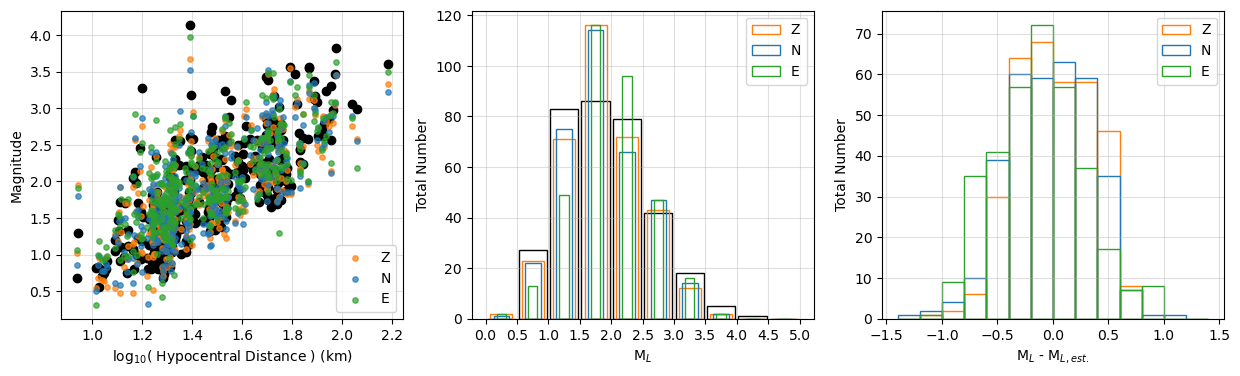

In [19]:
x_events = range(len(data_amax))

hdist = np.log10(data_amax.Hdistance_km)

mm = data_amax.Magnitude

diff_z, diff_n, diff_e = mm-mm_z, mm-mm_n, mm-mm_e

__makeplot_magnitude_comparison()

## Fitting Translation Data

In [20]:
def __ml_fit(X, a, b, c):
    amax, hdist = X
    return np.log10(amax) + a*np.log10(hdist) + b*hdist - c

In [21]:
def __predict_local_amplitude_ml(X):
    mag, hdist = X
    return 10**( mag - 1.11*np.log10(hdist) - 0.00189*hdist +  2.09)

In [22]:
def __predict_local_amplitude(X, a, b, c):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b*hdist + c )

In [23]:
## select amplitude data
amax_n = data_amax_cosum_6.PFO_10_N_amax*1e9
amax_e = data_amax_cosum_6.PFO_10_E_amax*1e9

## select hypocentral distances and magnitudes
hdist = data_amax_cosum_6.Hdistance_km
mag = data_amax_cosum_6.Magnitude

## perform data fitting
popt_n, pcov_n = curve_fit(__ml_fit, (amax_n, hdist), mag, p0=(1., 0.001, 2.))
popt_e, pcov_e = curve_fit(__ml_fit, (amax_e, hdist), mag, p0=(1., 0.001, 2.))

## output the new laws
print(f"\n N_trans:   Ml = log10(Amax) + {popt_n[0]:.2f} log10(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}")
print(f"\n E_trans:   Ml = log10(Amax) + {popt_e[0]:.2f} log10(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}")

## generate synthetic magnitudes
syn_data_e = __ml_fit((amax_e, hdist), popt_e[0], popt_e[1], popt_e[2])
syn_data_n = __ml_fit((amax_n, hdist), popt_n[0], popt_n[1], popt_n[2])

## compute differences of magnitudes and synthetics
diff_syn_n = mag-syn_data_n
diff_syn_e = mag-syn_data_e

## compute synthetic maximal amplitudes
amax_syn = __predict_local_amplitude_ml((mag, hdist))
amax_syn_n = __predict_local_amplitude((mag, hdist), popt_n[0], popt_n[1], popt_n[2])
amax_syn_e = __predict_local_amplitude((mag, hdist), popt_e[0], popt_e[1], popt_e[2])


 N_trans:   Ml = log10(Amax) + 0.98 log10(R) + 0.00612 R + 5.07

 E_trans:   Ml = log10(Amax) + 1.03 log10(R) + 0.00733 R + 5.29


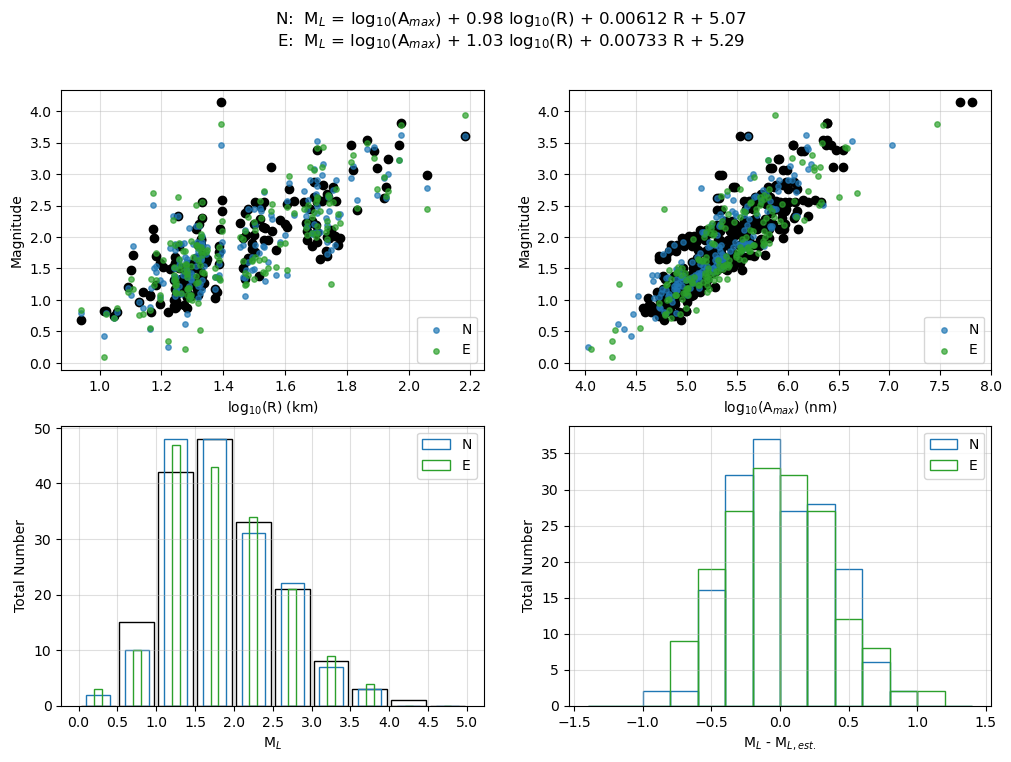

In [24]:
def __makeplot_magnitude_comparison2():

    fig, ax = plt.subplots(2,2, figsize=(12,8))

    ## ______________________________________________________________

    ax[0,0].scatter(np.log10(hdist), mag, color='k', zorder=3)
    ax[0,0].scatter(np.log10(hdist), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0,0].scatter(np.log10(hdist), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0,0].grid(zorder=0, alpha=0.4)
    ax[0,0].legend(loc=4)

    ax[0,0].set_xlabel(r"log$_{10}$(R) (km)")
    ax[0,0].set_ylabel("Magnitude")


    ## ______________________________________________________________

    ax[0,1].scatter(np.log10(amax_syn_n), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax_syn_e), mag, color='k', zorder=3)

    ax[0,1].scatter(np.log10(amax_n), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0,1].scatter(np.log10(amax_e), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0,1].grid(zorder=0, alpha=0.4)
    ax[0,1].legend(loc=4)

    ax[0,1].set_xlabel(r"log$_{10}$(A$_{max}$) (nm)")
    ax[0,1].set_ylabel("Magnitude")


    ## ______________________________________________________________

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mag, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    # ax[1,1].hist(mag_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               # color="tab:orange", edgecolor="tab:orange", rwidth=0.7, fill=False, align="mid", label="Z")
    ax[1,0].hist(syn_data_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N")
    ax[1,0].hist(syn_data_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.2, fill=False, align="mid", label="E")
    ax[1,0].set_xticks(bars)

    ax[1,0].legend(loc=1)
    ax[1,0].grid(zorder=0, alpha=0.4)

    ax[1,0].set_xlabel(r"M$_L$")
    ax[1,0].set_ylabel("Total Number")


    ## ______________________________________________________________


    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)

    # ax[2].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
    #            color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[1,1].hist(diff_syn_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[1,1].hist(diff_syn_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")

    ax[1,1].legend(loc=1)
    ax[1,1].grid(zorder=0, alpha=0.4)

    ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[1,1].set_ylabel("Total Number")



    ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
    law1 = f"{ml_str} = {log10_str}({amax_str}) + {popt_n[0]:.2f} {log10_str}(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}"
    law2 = f"{ml_str} = {log10_str}({amax_str}) + {popt_e[0]:.2f} {log10_str}(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}"
    plt.suptitle(f" N:  {law1}  \nE:  {law2}")

    plt.show();
    return fig

fig = __makeplot_magnitude_comparison2()

# fig.savefig(config['path_to_figs']+"BSPF_magnitudescales_translationsNE.png", format="png", dpi=200, bbox_inches='tight')

## Fitting Rotation Data

In [25]:
## select amplitude data
amax_n = data_amax_cosum_6.BSPF__N_amax
amax_e = data_amax_cosum_6.BSPF__E_amax
amax_z = data_amax_cosum_6.BSPF__Z_amax

## select hypocentral distances and magnitudes
hdist = data_amax_cosum_6.Hdistance_km
mag = data_amax_cosum_6.Magnitude

## perform data fitting
popt_n, pcov_n = curve_fit(__ml_fit, (amax_n, hdist), mag, p0=(1., 0.001, 1.))
popt_e, pcov_e = curve_fit(__ml_fit, (amax_e, hdist), mag, p0=(1., 0.001, 1.))
popt_z, pcov_z = curve_fit(__ml_fit, (amax_z, hdist), mag, p0=(1., 0.001, 1.))

## output the new laws
print(f"\n N_rot:   Ml = log10(Amax) + {popt_n[0]:.2f} log10(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}")
print(f"\n E_rot:   Ml = log10(Amax) + {popt_e[0]:.2f} log10(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}")
print(f"\n Z_rot:   Ml = log10(Amax) + {popt_z[0]:.2f} log10(R) + {popt_z[1]:.5f} R + {popt_z[2]:.2f}")

## generate synthetic magnitudes
syn_data_e = __ml_fit((amax_e, hdist), popt_e[0], popt_e[1], popt_e[2])
syn_data_n = __ml_fit((amax_n, hdist), popt_n[0], popt_n[1], popt_n[2])
syn_data_z = __ml_fit((amax_z, hdist), popt_z[0], popt_z[1], popt_z[2])

## compute differences of magnitudes and synthetics
diff_syn_n = mag-syn_data_n
diff_syn_e = mag-syn_data_e
diff_syn_z = mag-syn_data_z


## compute synthetic maximal amplitudes
amax_syn = __predict_local_amplitude_ml((mag, hdist))
amax_syn_n = __predict_local_amplitude((mag, hdist), popt_n[0], popt_n[1], popt_n[2])
amax_syn_e = __predict_local_amplitude((mag, hdist), popt_e[0], popt_e[1], popt_e[2])
amax_syn_z = __predict_local_amplitude((mag, hdist), popt_z[0], popt_z[1], popt_z[2])


 N_rot:   Ml = log10(Amax) + 1.71 log10(R) + 0.00410 R + -5.51

 E_rot:   Ml = log10(Amax) + 1.72 log10(R) + 0.00437 R + -5.67

 Z_rot:   Ml = log10(Amax) + 1.84 log10(R) + 0.00430 R + -5.58


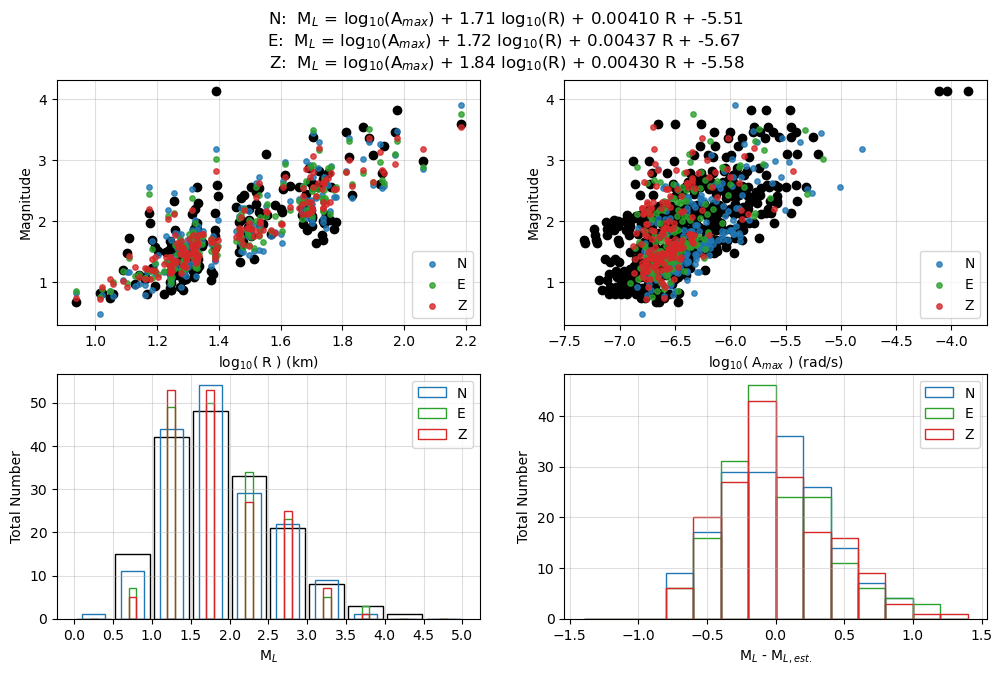

In [26]:
def __makeplot_magnitude_comparison3():

    fig, ax = plt.subplots(2, 2, figsize=(12, 7))

    ## ______________________________________________________________

    ax[0,0].scatter(np.log10(hdist), mag, zorder=3, color="black")
    ax[0,0].scatter(np.log10(hdist), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.8)
    ax[0,0].scatter(np.log10(hdist), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.8)
    ax[0,0].scatter(np.log10(hdist), syn_data_z, s=15, zorder=3, label="Z", edgecolors="tab:red", color="tab:red", alpha=0.8)

    ax[0,0].grid(zorder=0, alpha=0.4)
    ax[0,0].legend(loc=4)

    ax[0,0].set_xlabel(r"log$_{10}$( R ) (km)")
    ax[0,0].set_ylabel("Magnitude")


    ## ______________________________________________________________

    ax[0,1].scatter(np.log10(amax_syn_n), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax_syn_e), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax_syn_z), mag, color='k', zorder=3)

    ax[0,1].scatter(np.log10(amax_n), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.8)
    ax[0,1].scatter(np.log10(amax_e), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.8)
    ax[0,1].scatter(np.log10(amax_z), syn_data_z, s=15, zorder=3, label="Z", edgecolors="tab:red", color="tab:red", alpha=0.8)

    ax[0,1].grid(zorder=0, alpha=0.4)
    ax[0,1].legend(loc=4)

    ax[0,1].set_xlabel(r"log$_{10}$( A$_{max}$ ) (rad/s)")
    ax[0,1].set_ylabel("Magnitude")


    ## ______________________________________________________________

    dbars = 0.5
    bars = np.arange(0, 5 + dbars, dbars)

    # labels, counts = np.unique(mag, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    ax[1,0].hist(syn_data_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N")
    ax[1,0].hist(syn_data_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.2, fill=False, align="mid", label="E")
    ax[1,0].hist(syn_data_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:red", edgecolor="tab:red", rwidth=0.2, fill=False, align="mid", label="Z")

    ax[1,0].set_xticks(bars)
    # ax[1,0].set_xticks(bars+dbars/2)
    # ax[1,0].set_xticklabels([f"{b}-{b+dbars}" for b in bars], rotation=60)

    ax[1,0].legend(loc=1)
    ax[1,0].grid(zorder=0, alpha=0.4)

    ax[1,0].set_xlabel(r"M$_L$")
    ax[1,0].set_ylabel("Total Number")


    ## ______________________________________________________________

    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)
    # ax[1,1].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
    #            color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[1,1].hist(diff_syn_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[1,1].hist(diff_syn_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")
    ax[1,1].hist(diff_syn_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:red", edgecolor="tab:red", rwidth=1, fill=False, align="mid", label="Z")

    ax[1,1].legend(loc=1)
    ax[1,1].grid(zorder=0, alpha=0.4)

    ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[1,1].set_ylabel("Total Number")


    ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
    law1 = f"{ml_str} = {log10_str}({amax_str}) + {popt_n[0]:.2f} {log10_str}(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}"
    law2 = f"{ml_str} = {log10_str}({amax_str}) + {popt_e[0]:.2f} {log10_str}(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}"
    law3 = f"{ml_str} = {log10_str}({amax_str}) + {popt_z[0]:.2f} {log10_str}(R) + {popt_z[1]:.5f} R + {popt_z[2]:.2f}"
    plt.suptitle(f" N:  {law1}  \nE:  {law2}  \nZ:  {law3}")

    plt.show();
    return fig

fig = __makeplot_magnitude_comparison3()

fig.savefig(config['path_to_figs']+"BSPF_magnitudescales_rotationsNEZ.png", format="png", dpi=200, bbox_inches='tight')

## Minimal Amplitude

In [27]:
def __predict_local_magnitude(X, a, b, c):
    amp, hdist = X
    return np.log10(amp) + a*np.log10(hdist) + b*hdist - c

In [28]:

a_n, b_n, c_n = popt_n[0], popt_n[1], popt_n[2]
a_e, b_e, c_e = popt_e[0], popt_e[1], popt_e[2]
a_z, b_z, c_z = popt_z[0], popt_z[1], popt_z[2]


hdist = np.arange(1, 125+1, 1)
mag = np.arange(-1, 6.0+0.1, 0.1)

amax_syn_n = np.zeros((len(hdist), len(mag)))
amax_syn_e = np.zeros((len(hdist), len(mag)))
amax_syn_z = np.zeros((len(hdist), len(mag)))

for i, h in enumerate(hdist):
    for j, m in enumerate(mag):
        amax_syn_n[i, j] = __predict_local_amplitude((m, h), a_n, b_n, c_n)
        amax_syn_e[i, j] = __predict_local_amplitude((m, h), a_e, b_e, c_e)
        amax_syn_z[i, j] = __predict_local_amplitude((m, h), a_z, b_z, c_z)


In [29]:
bspf_e = data_amax_cosum_6.BSPF__E_amax
bspf_n = data_amax_cosum_6.BSPF__N_amax
bspf_z = data_amax_cosum_6.BSPF__Z_amax

bspf_mag = data_amax_cosum_6.Magnitude
bspf_hdist = data_amax_cosum_6.Hdistance_km

## blueSeis self-noise
limit = 1.5e-7  ## rad/s
mag_limit_n = __predict_local_magnitude((limit, hdist), popt_n[0], popt_n[1], popt_n[2])
mag_limit_e = __predict_local_magnitude((limit, hdist), popt_e[0], popt_e[1], popt_e[2])
mag_limit_z = __predict_local_magnitude((limit, hdist), popt_z[0], popt_z[1], popt_z[2])

In [30]:
def __makeplot_single():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(28)
    # cmap = mpl.colormaps['rainbow'].resampled(11)
    # cmap.set_under('gray')


    amin_n, amax_n = min(amax_syn_n.reshape(1, amax_syn_n.size)[0]), max(amax_syn_n.reshape(1, amax_syn_n.size)[0])
    amin_e, amax_e = min(amax_syn_e.reshape(1, amax_syn_e.size)[0]), max(amax_syn_e.reshape(1, amax_syn_e.size)[0])
    amin_z, amax_z = min(amax_syn_z.reshape(1, amax_syn_z.size)[0]), max(amax_syn_z.reshape(1, amax_syn_z.size)[0])

    amin, amax = min(amin_n, amin_e, amin_z), max(amax_n, amax_e, amax_z)

    # lev = np.logspace(round(np.log10(amin),0), round(np.log10(amax),0), 10)
    # lev = np.logspace(amin, amax, levels)
    # lev_lbl = np.linspace(amin, amax, levels).astype(int)
    lev = np.array([1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)

    ax[0].scatter(bspf_mag, bspf_hdist, c=bspf_n, s=40, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                  norm=mpl.colors.LogNorm(vmin=amin, vmax=amax))
    cb0 = ax[0].contourf(mag, hdist, amax_syn_n, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    cb1 = ax[1].scatter(bspf_mag, bspf_hdist, c=bspf_e, s=40, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                        norm=mpl.colors.LogNorm(vmin=amin, vmax=amax))
    ax[1].contourf(mag, hdist, amax_syn_e, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    cb2 = ax[2].scatter(bspf_mag, bspf_hdist, c=bspf_z, s=40, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                        norm=mpl.colors.LogNorm(vmin=amin_z, vmax=amax_z))
    ax[2].contourf(mag, hdist, amax_syn_z, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    ax[0].plot(mag_limit_n, hdist, color="tab:red", ls="--")
    ax[1].plot(mag_limit_e, hdist, color="tab:red", ls="--")
    ax[2].plot(mag_limit_z, hdist, color="tab:red", ls="--")

    for jj in range(3):
        ax[jj].set_xlim(-1, 6)
        ax[jj].set_ylim(1, 70)

    cbar0 = plt.colorbar(cb0, ax=ax, extend='min')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label("max. Amplitude (rad/s)", labelpad=-70, fontsize=font)

    ax[0].set_xlabel("Magnitude", fontsize=font)
    ax[0].set_ylabel("Hypocentral Distance (km)", fontsize=font)
    ax[1].set_xlabel("Magnitude", fontsize=font)
    ax[2].set_xlabel("Magnitude", fontsize=font)

    # ax[1].set_ylabel("Hypocentral Distance (km)")

    ax[0].set_title("BSPF-N")
    ax[0].set_title("BSPF-N")
    ax[1].set_title("BSPF-E")
    ax[2].set_title("BSPF-Z")

    plt.show();
    return fig

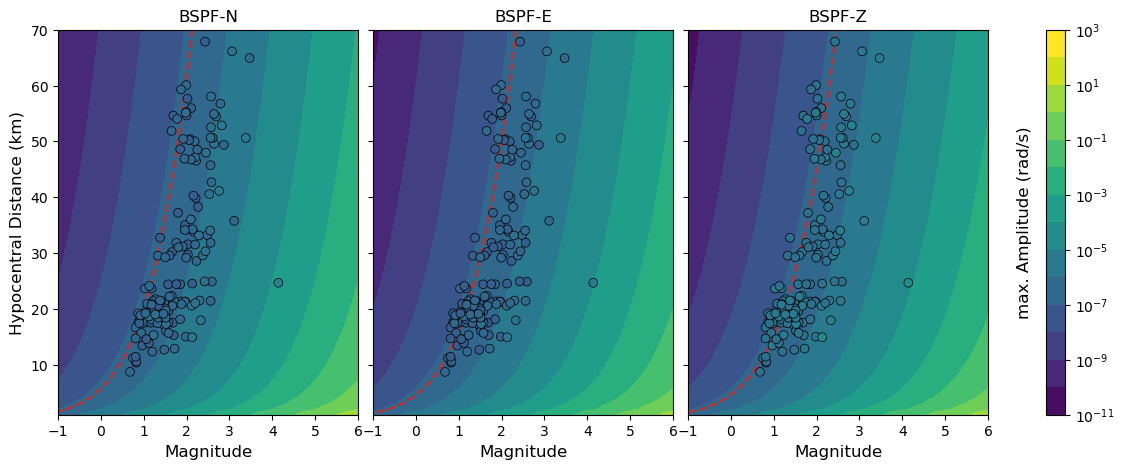

In [31]:
fig = __makeplot_single();

fig.savefig(config['path_to_figs']+"BSPF_model_magnitudescale_components.png", format="png", dpi=200, bbox_inches='tight')

## New fitting

In [32]:
# data_amax_cosum_6  = data_amax_cosum_6[data_amax_cosum_6.Magnitude > 2.5]


In [33]:
def __ml_fit(X, a, b):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b )


def __predict_amplitude(X, a, b):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b )


def __predict_magnitude(X, a, b):
    amax, hdist = X
    return np.log10(amax) + a*np.log10(hdist) + b


In [34]:
mag_grey = np.array(events_not_triggered.magnitude)
hdist_grey = np.array(events_not_triggered.Hdistance_km)

## select amplitude data
amax_n = np.array(data_amax.BSPF__N_amax)
amax_e = np.array(data_amax.BSPF__E_amax)
amax_z = np.array(data_amax.BSPF__Z_amax)

amax_all = np.sqrt(amax_n**2 + amax_e**2 + amax_z**2) #/2 /np.pi

## create uncertainties
data_amax['sigma'] = 1.0*np.ones(data_amax.shape[0])
data_amax['sigma'] = data_amax.sigma.where(data_amax.Magnitude > 2.5, 0.1)
sigmas = np.array(data_amax.sigma)

## select hypocentral distances and magnitudes
hdist_all = np.array(data_amax.Hdistance_km)
mag_all = np.array(data_amax.Magnitude)

## Append M62 event data
amax_all = np.append(amax_all, np.sqrt(5.4e-07**2 + 5.3e-07**2 + 1.4e-06**2)) #/2 /np.pi
mag_all = np.append(mag_all, 6.2)
hdist_all = np.append(hdist_all, 312)
sigmas = np.append(sigmas, 1.0)


## perform data fitting
# p0 = (1.11, 0.00189, 2.09)
popt_all, pcov_all = curve_fit(__ml_fit, (mag_all, hdist_all), amax_all,
                               check_finite=True,
                               p0=(1, 1.),
                               bounds=([0, 0],[5, 5]),
                               sigma=sigmas,
                              )

# popt_all[0], popt_all[1] = 4, 1.5



## output the new laws
print(f"\n Ml = log10(Amax) + {popt_all[0]:.2f} log10(R) + {popt_all[1]:.2f}")

## generate synthetic magnitudes
# syn_data_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1], popt_all[2])

## compute differences of magnitudes and synthetics
# diff_syn_all = mag_all-syn_data_all


## compute synthetic maximal amplitudes
amax_syn_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1])

amax_syn_grey = __predict_amplitude((mag_grey, hdist_grey), popt_all[0], popt_all[1])


## ______________________________________

a_all, b_all = popt_all[0], popt_all[1]


hdist_syn = np.arange(1, 350+1, 1)
mag_syn = np.arange(-1, 6.5+0.1, 0.1)

amax_syn_all = np.zeros((len(hdist_syn), len(mag_syn)))

for i, h in enumerate(hdist_syn):
    for j, m in enumerate(mag_syn):
        amax_syn_all[i, j] = __predict_amplitude((m, h), a_all, b_all)


## blueSeis self-noise
limit = 1.5e-7  #/2 /np.pi ## rad/s/Hz
mag_limit_all = __predict_magnitude((limit, hdist_syn), a_all, b_all)


## blueSeis self-noise
limit_1hz = 1.0e-8  #/2 /np.pi ## rad/s/Hz
mag_limit_all_1hz = __predict_magnitude((limit_1hz, hdist_syn), a_all, b_all)

limit_10hz = 3.0e-8  #/2 /np.pi ## rad/s/Hz
mag_limit_all_10hz = __predict_magnitude((limit_10hz, hdist_syn), a_all, b_all)



 Ml = log10(Amax) + 3.26 log10(R) + 3.80


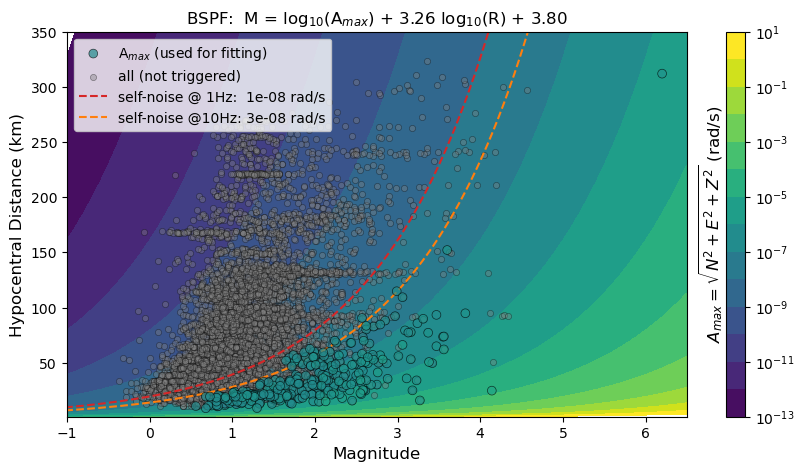

In [35]:
def __makeplot_all():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(28)
    # cmap = mpl.colormaps['jet'].resampled(28)
    cmap.set_under('gray')


    # amin_all, amax_all = min(amax_syn_all.reshape(1, amax_syn_all.size)[0]), max(amax_syn_all.reshape(1, amax_syn_all.size)[0])

    lev = np.array([1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)


    ax.scatter(mag_all, hdist_all, c=amax_all, s=40, cmap=cmap, edgecolors="black", alpha=0.7, lw=0.5, zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), label=r"A$_{max} $ (used for fitting)")

    ax.scatter(mag_grey, hdist_grey, s=20, color="grey", edgecolors="black", lw=0.5, zorder=2, alpha=0.4, label="all (not triggered)")


    cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)
    # cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, levels=lev)

    # ax.plot(mag_limit_all, hdist_syn, color="tab:red", ls="--", label=f"self-noise: {limit} rad/s")
    ax.plot(mag_limit_all_1hz, hdist_syn, color="tab:red", ls="--", label=f"self-noise @ 1Hz:  {limit_1hz} rad/s")
    ax.plot(mag_limit_all_10hz, hdist_syn, color="tab:orange", ls="--", label=f"self-noise @10Hz: {limit_10hz} rad/s")

    ax.set_xlim(-1, 6.5)
    ax.set_ylim(1, 350)

    cbar0 = plt.colorbar(cb0, ax=ax, extend='min')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label(r"$A_{max} = \sqrt{N^2 + E^2 + Z^2}$ (rad/s)", labelpad=-70, fontsize=font)

    ax.set_xlabel("Magnitude", fontsize=font)
    ax.set_ylabel("Hypocentral Distance (km)", fontsize=font)

    ax.set_title(r"BSPF:  M = log$_{10}$(A$_{max}$)" + f" + {popt_all[0]:.2f}" + " log$_{10}$" +f"(R) + {popt_all[1]:.2f}")

    ax.legend(loc=2)

    plt.show();
    return fig

fig = __makeplot_all();

fig.savefig(config['path_to_figs']+"BSPF_model_magnitudescale_overview.png", format="png", dpi=200, bbox_inches='tight')